In [1]:
from sklearn.manifold import TSNE
import torch
from time import time
import pickle
import torch
import numpy as np
import json
import torchvision
import torchvision.transforms as transforms

import sys
sys.path.append("models")
import os
import torchvision.transforms as T
from collections import Counter
from AlexNet_SVHN import AlexNet

import torchvision.datasets as datasets
import random
import torch.utils.data as Data
import gc
from sklearn.cluster import KMeans
import numpy as np
from utils_data import *
from get_all_similarities import sim_units, sim_paths, sim_samples, sim_samples_cluster, get_random_samples, sim_samples_oneone

In [2]:
def get_picked_samples(dataset="cifar10", arch="alxnet", attack="", attack_epi=0.03, ori_model=None, data_loader=None):
    # get sample indexs of every class
    samples_class = [[] for _ in range(10)]
    root_path = "samples_class/"
    if attack == "":
        samples_class_file = root_path + "samples_class_{}_{}.pkl".format(dataset, arch)
    else:    
        samples_class_file = root_path + "samples_class_{}_{}_{}{}.pkl".format(dataset, arch, attack, attack_epi)

    if os.path.exists(samples_class_file):
        with open(samples_class_file, "rb") as f:
            unpickler = pickle.Unpickler(f)
            samples_class = unpickler.load()
    else: 
        start_index = end_index = 0
        for step, (val_x, val_y) in enumerate(data_loader):
            start_index = end_index
            print("step:", step)
            val_x = val_x.cuda()
            val_y = val_y
            val_output = ori_model(val_x)
            _, val_pred_y = val_output.max(1)
            for i, t in enumerate(val_pred_y):
                if attack == "":
                    if t == val_y[i]:
                        samples_class[t].append(i+start_index)
                else:
                    if t != val_y[i]:
                        samples_class[t].append(i+start_index)
            end_index = start_index + val_x.shape[0]

        output = open(samples_class_file, 'wb')
        pickle.dump(samples_class, output)  

    print("Done!")
    return samples_class

In [3]:
#  set parameters
dataset = "cifar10"
arch = "convcifar10"
attack_mode = "pgd"
attack_epi = 0.03
batch_size = 640

test_data = get_test_dataset(dataset)
adv_data = get_adv_dataset(attack_mode, dataset, arch, attack_epi)

test_dataloader = get_test_dataloader(dataset, batch_size)
adv_dataloader = get_adv_dataloader(attack_mode, dataset, arch, attack_epi, batch_size)

model, layer_names, num_layer = get_model(dataset, arch)
model = model.cuda()
model.eval()

sample_threshold, cluster_threshold, cluster_num = get_cluster_para(dataset, arch)

samples_class_test = get_picked_samples(dataset, arch, "", 0, model, test_dataloader)
samples_class_adv = get_picked_samples(dataset, arch, attack_mode, attack_epi, model, adv_dataloader)

# get all samples' paths
test_paths_path = f"LRP_path/{dataset}_{arch}_lrp_path_threshold{sample_threshold}_test.pkl"
adv_paths_path = f"LRP_path/pgd{str(attack_epi)}_{arch}_lrp_path_threshold{sample_threshold}_test.pkl"
with open(test_paths_path, 'rb') as fr:
    test_paths = pickle.load(fr)
with open(adv_paths_path, 'rb') as fr:
    adv_paths = pickle.load(fr)
    
cluster_paths = [[] for _ in range(10)]
for cla in range(10):
    for clu in range(cluster_num):
        path_fname = f"cluster_paths/{arch}_binary_cluster/num_cluster{cluster_num}_threshold{cluster_threshold}_class{cla}_cluster{clu}_paths.pkl"
#         print(path_fname)
        with open(path_fname, "rb") as f:
            unpickler = pickle.Unpickler(f)
            cluster_paths[cla].append(unpickler.load()[0])

Files already downloaded and verified
(10000, 32, 32, 3)
Done!
Done!


In [6]:
def getAllSims(samples_class, paths, num_cluster, cluster_paths):
    s_all = 0
    s_alls = []
    sims_all = None
    num = 0
    for cla in range(10):
        print("class:", cla)
        for index in samples_class[cla]:
            max_s = 0
            for clu in range(num_cluster):     
                s, sims = sim_paths(paths[index], cluster_paths[cla][clu], mode="jaccard")
                if s > max_s:
                    max_s = s
                    temp_sims = sims
            s_all += max_s
            s_alls.append(max_s)
            if sims_all is None:
                sims_all = temp_sims
            else:
                for i in range(len(sims_all)):
                    sims_all[i] += temp_sims[i]
            num += 1
        print("\t", s_all/num)
        
    print(s_all/num)
    for i in range(len(sims_all)):
        sims_all[i] = sims_all[i]/num
    print(sims_all)
    return s_alls

# get all samples' paths
def get_len(paths):
    lens = [0 for _ in range(len(paths[0]))]
    num = 0
    for key in paths.keys():
        num += 1
        path = paths[key]
        for i, p in enumerate(path):
            lens[i] += len(p)
    lens = [lens[i]/num for i in range(len(lens))]
    print(num, lens)
    return lens

def get_cluster_len(paths):
    lens = [0 for _ in range(len(paths[0][0]))]
    num = 0
    for cla in range(10):
        for clu in range(len(paths[cla])):
            for i, p in enumerate(paths[cla][clu]):
                lens[i] += len(p)
            num += 1
    lens = [lens[i]/num for i in range(len(lens))]
    print(num, lens)
    return lens

In [9]:
test_lens = get_len(test_paths)
adv_lens = get_len(adv_paths)
clusters_lens = get_cluster_len(cluster_paths)

# print(len(test_paths[0]))
# print(len(cluster_paths[0][0]))
s_alls = getAllSims(samples_class_test, test_paths, cluster_num, cluster_paths)
adv_s_alls = getAllSims(samples_class_adv, adv_paths, cluster_num, cluster_paths)

10000 [7.0573, 11.1813, 22.6699, 18.813, 15.6628, 20.3043, 116.1044, 34.8047]
10000 [7.1554, 11.6658, 23.3154, 18.1771, 10.237, 17.398, 113.6229, 35.9226]
100 [6.47, 9.69, 17.58, 11.47, 8.95, 17.53, 99.22, 33.34]
class: 0
	 0.6016366197183094
class: 1
	 0.63896912858661
class: 2
	 0.6139627306273066
class: 3
	 0.6064630699518548
class: 4
	 0.6059612350687386
class: 5
	 0.6077911380420367
class: 6
	 0.6148880527415971
class: 7
	 0.6172432330300897
class: 8
	 0.6228358784284636
class: 9
	 0.6275233731739698
0.6275233731739698
[0.730431308100929, 0.5997231518370898, 0.5338417662682647, 0.449046303674196, 0.4814446657813119, 0.6825966578131968, 0.6883548472775523, 0.8547442452412454]
class: 0
	 0.6162219204655675
class: 1
	 0.6432174034695015
class: 2
	 0.6184420609884312
class: 3
	 0.6372071820677009
class: 4
	 0.6398545388127816
class: 5
	 0.6357539436409683
class: 6
	 0.6411227839789848
class: 7
	 0.6418278753400919
class: 8
	 0.6444845174491288
class: 9
	 0.6510367849602869
0.651036784

class: 0
	 0.33126576381365114
class: 1
	 0.39359017003188057
class: 2
	 0.3735702583025828
class: 3
	 0.38390829793259706
class: 4
	 0.37326700473292823
class: 5
	 0.384422022344254
class: 6
	 0.37819107573564925
class: 7
	 0.3755562911126668
class: 8
	 0.3716417716827284
class: 9
	 0.3719132470119532
0.3719132470119532
[0.7363068282425934, 0.5602644422310737, 0.4826926848162944, 0.3099695329791905, 0.17442371624612765, 0.18362706949977534, 0.2103847498893307, 0.31762943780433456]


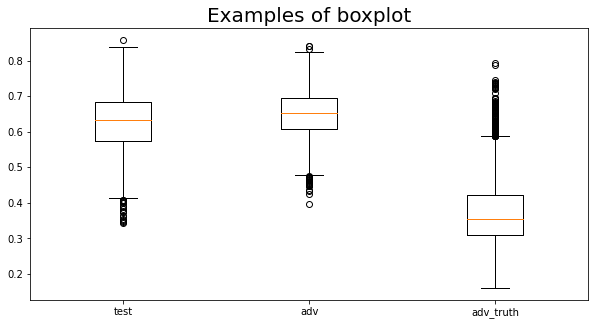

In [11]:
adv_truth_alls = getAllSims(samples_class_test, adv_paths, cluster_num, cluster_paths)

import matplotlib.pyplot as plt

box_1, box_2, box_3 = s_alls, adv_s_alls, adv_truth_alls
 
plt.figure(figsize=(10,5))#设置画布的尺寸
plt.title('Examples of boxplot',fontsize=20)#标题，并设定字号大小
labels = 'test','adv', "adv_truth"#图例
plt.boxplot([box_1, box_2, box_3], labels = labels)#grid=False：代表不显示背景中的网格线
# data.boxplot()#画箱型图的另一种方法，参数较少，而且只接受dataframe，不常用
plt.show()#显示图像


In [ ]:
dataset = "cifar10"
arc = "vgg"
attack = "pgd"
attack_epi = 0.03

data_path = f"LRP_path/{dataset}_{arc}_lrp_path_threshold0.7_train.pkl"
with open(data_path, 'rb') as fr:
    paths = pickle.load(fr)
    
adv_paths_path = "LRP_path/pgd" + str(attack_epi) + "_" + arc + "_lrp_path_threshold0.7_test.pkl"
with open(adv_paths_path, 'rb') as fr:
    adv_paths = pickle.load(fr)


lens = get_len(paths)
adv_lens = get_len(adv_paths)

In [7]:
dataset = "cifar10"
arc = "vgg"
attack = "pgd"
attack_epi = 0.03

data_path = f"LRP_path/{dataset}_{arc}_lrp_path_threshold0.7_train.pkl"
with open(data_path, 'rb') as fr:
    paths = pickle.load(fr)
    
adv_paths_path = "LRP_path/pgd" + str(attack_epi) + "_" + arc + "_lrp_path_threshold0.7_test.pkl"
with open(adv_paths_path, 'rb') as fr:
    adv_paths = pickle.load(fr)


lens = get_len(paths)
adv_lens = get_len(adv_paths)

[8.941384441077304, 20.679552807240263, 23.177157131741676, 13.018714935091527, 14.600911858252454]
